In [63]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers.optimization import get_cosine_schedule_with_warmup

# Deep Average Network для определения сентимента 

In [3]:
def load_embeddings(path, num_tokens=100_000):
    """
    Load by file path no more emdeddings than tokens number.

    path -- file path to embeddings
    num_tokens -- tokens number (default 100_000)
    """
    token2index: Dict[str, int] = {}
    embeddings = []
    with open(path) as file_object:
        vocab_size, embedding_dim = file_object.readline().strip().split()
        vocab_size, embedding_dim = int(vocab_size), int(embedding_dim)
        num_tokens = vocab_size if num_tokens <= 0 else num_tokens
        token2index['PAD'] = 0
        embeddings.append(np.zeros(embedding_dim))
        token2index['UNK'] = 1
        embeddings.append(np.ones(embedding_dim))
        for line in tqdm(file_object, total=num_tokens, desc='Reading embeddings file'):
            parts = line.strip().split()
            token = ' '.join(parts[:-embedding_dim]).lower()
            if token in token2index:
                continue
            embedding = np.array(list(map(float, parts[-embedding_dim:])))
            token2index[token] = len(token2index)
            embeddings.append(embedding)
            if len(token2index) == num_tokens:
                break
    embeddings_matrix: np.array = np.array(embeddings)
    assert(len(token2index) == embeddings_matrix.shape[0])
    
    return token2index, embeddings_matrix

In [4]:
!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2022-02-10 06:11:34--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  25.4MB/s    in 50s     

2022-02-10 06:12:25 (25.0 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]

gzip: cc.ru.300.vec already exists; do you wish to overwrite (y or n)? н
	not overwritten


## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [5]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [6]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [7]:
for batch in train_loader:
    break

batch

{'label': tensor([2, 0]),
 'text': ['John Cena has been named as the 2nd most Charitable Athlete in the world..  1st. C Ronaldo-  2nd .John Cena  and...',
  'Happy Friday: A health worker who may have had contact with Ebola is on a frigging cruise ship']}

In [11]:
def empty_collate(batch):
    return batch

In [12]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [13]:
for batch in train_loader:
    break

batch

[{'label': 1,
  'text': 'De Biasi (coach ALB): "Ronaldo better keeps quiet tomorrow or Messi will get my vote for the Ballon d\'Or this time."'},
 {'label': 1,
  'text': 'Kane returns Monday on #Raw will we see the mask or not #WWE'}]

In [44]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        tokens_indices = [self.token2index.get(token, self.unk_index) 
                          for token in tokenized_text]
        return tokens_indices
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        padded_indices = [self.pad_index] * self.max_length
        for i, token_i in enumerate(tokens_indices[:self.max_length]):
            padded_indices[i] = token_i
            
        return padded_indices
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        return self.padding(self.indexing(self.tokenize(text)))
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            tokenized_texts.append(self(sample['text']))
            labels.append(sample['label'])
            
        tokenized_texts = torch.LongTensor(tokenized_texts)  # перевод в torch.Tensor
        labels = torch.LongTensor(labels)  # перевод в torch.Tensor
        
        return tokenized_texts, labels

In [45]:
batch_size = 128

In [46]:
token2index, embeddings_matrix = load_embeddings("/content/cc.ru.300.vec")

Reading embeddings file: 117085it [00:11, 10615.63it/s]


In [47]:
tokenizer = Tokenizer(
    base_tokenizer=ToktokTokenizer(),
    token2index=token2index,
    pad_token="PAD",
    unk_token="UNK",
    max_length=batch_size
)

In [48]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=tokenizer.collate)

In [49]:
for x, y in train_loader:
    break

In [50]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Я выбрала метрику Accuracy
Почему я выбрала эту метрику:  
в обзорной статье о различных подходов к sentiment-анализу в твиттере Giachanou, A., & Crestani, F. (2016). Like it or not: A survey of twitter sentiment analysis methods (https://dl.acm.org/doi/abs/10.1145/2938640) авторы называют метрику Accuracy самым популярным выбором, поскольку фактически это проблема классификации, и Accuracy -- классическая метрика для нее. Эта метрика оценивает, как часто модель делает верное предсказание.

In [91]:
class DeepAverageNetwork(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.embedding_layer = nn.EmbeddingBag.from_pretrained(
            embeddings=torch.from_numpy(embedding_matrix).to(torch.float32),
            mode='mean',
            padding_idx=0,
            max_norm=10.0,
            freeze=False,
        )
        self.linear = nn.Linear(embedding_matrix.shape[1], batch_size*2)
        self.relu = nn.ReLU()
        self.output = nn.Linear(batch_size*2, 3)
        self.bnorm = nn.BatchNorm1d(batch_size*2)
        
    def forward(self, x):
        x_embed = self.embedding_layer(x)
        x_embed = self.linear(x_embed)
        x_embed = self.relu(x_embed)
        x_embed = self.bnorm(x_embed)
        x_embed = self.output(x_embed)
        
        return x_embed

In [92]:
model = DeepAverageNetwork(embeddings_matrix)
device = torch.device('cuda')

## Задайте функцию потерь и оптимизатор

In [93]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

## Сделайте цикл обучения

In [94]:
NUM_EPOCHS = 7  # Задайте количество эпох
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

warmup_ratio = 0.3
num_training_steps = len(train_loader) * NUM_EPOCHS
num_warmup = int(round(num_training_steps * warmup_ratio))

lr_sched = get_cosine_schedule_with_warmup(optimizer=optimizer, num_training_steps=num_training_steps, num_warmup_steps=num_warmup)

for n_epoch in range(NUM_EPOCHS):
    
    # train
    y_pred = []
    y_true = []
    epoch_loss = []
    for i, (x, y) in enumerate(tqdm(train_loader, desc=f"Train Epoch {n_epoch}")):
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss_value = loss(logits, y)
        loss_value.backward()
        optimizer.step()
        lr_sched.step()
        optimizer.zero_grad()
        
        epoch_loss.append(loss_value.item())
        
        with torch.no_grad():
            y_pred_batch = torch.argmax(torch.softmax(logits, -1), -1)
            y_pred_batch = y_pred_batch.detach().cpu().numpy()
            y_true_batch = y.detach().cpu().numpy()
            
            y_pred += list(y_pred_batch)
            y_true += list(y_true_batch)
                
    train_loss.append(np.mean(epoch_loss))
    ep_train_accuracy = accuracy_score(y_true, y_pred)
    train_accuracy.append(ep_train_accuracy)

    # validation
    epoch_val_loss = []
    with torch.no_grad():
        y_pred = []
        y_true = []
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            epoch_val_loss.append(loss(logits, y).item())
            y_pred_batch = torch.argmax(torch.softmax(logits, -1), -1).cpu().numpy()
            y_true_batch = y.cpu().numpy()
            
            y_pred += list(y_pred_batch)
            y_true += list(y_true_batch)
            
        ep_val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracy.append(ep_val_accuracy)
        val_loss.append(np.mean(epoch_val_loss))
    
    print(f"Train Accuracy: {ep_train_accuracy:.4f}, Val Accuracy: {ep_val_accuracy:.4f}")
    print(f"Train Loss: {np.mean(epoch_loss):.4f}, Val Loss: {np.mean(epoch_val_loss):.4f}")
    
# test
y_pred = []
y_true = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        y_pred_batch = torch.argmax(torch.softmax(logits, -1), -1).cpu().numpy()
        y_true_batch = y.cpu().numpy()

        y_pred += list(y_pred_batch)
        y_true += list(y_true_batch)
        
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Epoch 0: 100%|██████████| 357/357 [00:19<00:00, 18.26it/s]


Train Accuracy: 0.4913, Val Accuracy: 0.5550
Train Loss: 1.0076, Val Loss: 0.9281


Train Epoch 1: 100%|██████████| 357/357 [00:18<00:00, 19.06it/s]


Train Accuracy: 0.5830, Val Accuracy: 0.5565
Train Loss: 0.8886, Val Loss: 0.9047


Train Epoch 2: 100%|██████████| 357/357 [00:18<00:00, 19.52it/s]


Train Accuracy: 0.5999, Val Accuracy: 0.5750
Train Loss: 0.8581, Val Loss: 0.8861


Train Epoch 3: 100%|██████████| 357/357 [00:17<00:00, 20.08it/s]


Train Accuracy: 0.6162, Val Accuracy: 0.5890
Train Loss: 0.8334, Val Loss: 0.8773


Train Epoch 4: 100%|██████████| 357/357 [00:18<00:00, 19.25it/s]


Train Accuracy: 0.6265, Val Accuracy: 0.5905
Train Loss: 0.8147, Val Loss: 0.8798


Train Epoch 5: 100%|██████████| 357/357 [00:18<00:00, 19.13it/s]


Train Accuracy: 0.6356, Val Accuracy: 0.5965
Train Loss: 0.7995, Val Loss: 0.8781


Train Epoch 6: 100%|██████████| 357/357 [00:18<00:00, 19.83it/s]


Train Accuracy: 0.6417, Val Accuracy: 0.5940
Train Loss: 0.7883, Val Loss: 0.8824


100%|██████████| 96/96 [00:02<00:00, 41.93it/s]

Test Accuracy: 0.4907


In [95]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.13      0.21      3972
           1       0.55      0.68      0.61      5937
           2       0.36      0.63      0.46      2375

    accuracy                           0.49     12284
   macro avg       0.50      0.48      0.43     12284
weighted avg       0.53      0.49      0.45     12284



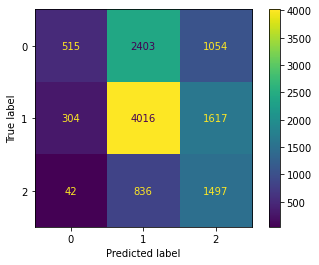

In [96]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

# Выводы


Результаты получились не очень впечатляющие, и я не уверена, в чем проблема. Хуже всего получилось с негативным лейблом, модели свойствено принимать его за нейтральный, а вот с нейтральным и позитивным нормально, при этом модель скорее путает их друг с другом, чем с негативными. Сложно сказать, почему так, может быть не хватило данных или они получились не очень качественными. Из личных успехов -- удалось написать что-то работающее без ошибок, хотелось бы делать это и дальше. 